In [27]:
#studied from https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile#Missing-Values-Analysis

#imports
import pandas as pd
import calendar
from datetime import datetime
import missingno as msno
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

In [5]:
#read files
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
#visualise
df_test.head()
df_train.head()
df_train.describe()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
#pre-process
df_train['date'] = df_train.datetime.apply(lambda x: x.split()[0])
df_train['time'] = df_train.datetime.apply(lambda x: x.split()[1])
df_train['season'] = df_train.season.map({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df_train['weather'] = df_train.weather.map({1: 'Clear, Few clouds, Partly cloudy, Partly cloudy', 
                                            2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                                            3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
                                            4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'})

df_train['hour'] = df_train.time.apply(lambda x: x.split(':')[0])
df_train['month'] = df_train.date.apply(lambda x: x.split('-')[1])
df_train['month'] = df_train.month.map({'01': 'Jan', '02': 'Feb', '03': 'Mar', '04': 'Apr', '05': 'May', '06':'June', '07': 'July', '08': 'Aug', '09': 'Sep', '10': 'Oct', '11':'Nov', '12': 'Dec'})
df_train['weekday'] = df_train.date.apply(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d').weekday()])
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,hour,month,weekday
0,2011-01-01 00:00:00,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81,0.0,3,13,16,2011-01-01,00:00:00,00,Jan,Saturday
1,2011-01-01 01:00:00,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0.0,8,32,40,2011-01-01,01:00:00,01,Jan,Saturday
2,2011-01-01 02:00:00,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0.0,5,27,32,2011-01-01,02:00:00,02,Jan,Saturday
3,2011-01-01 03:00:00,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0.0,3,10,13,2011-01-01,03:00:00,03,Jan,Saturday
4,2011-01-01 04:00:00,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0.0,0,1,1,2011-01-01,04:00:00,04,Jan,Saturday


In [8]:
#change to appropriate datatype
to_category = ['season', 'holiday', 'workingday', 'weather', 'hour', 'month', 'weekday']

for var in to_category:
    df_train[var] = df_train[var].astype('category')

In [9]:
#drop unnecessary columns
df_train.drop(['datetime', 'time'], axis = 1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,month,weekday
0,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,81,0.0000,3,13,16,2011-01-01,00,Jan,Saturday
1,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0.0000,8,32,40,2011-01-01,01,Jan,Saturday
2,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.02,13.635,80,0.0000,5,27,32,2011-01-01,02,Jan,Saturday
3,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0.0000,3,10,13,2011-01-01,03,Jan,Saturday
4,spring,0,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.84,14.395,75,0.0000,0,1,1,2011-01-01,04,Jan,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,winter,0,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",15.58,19.695,50,26.0027,7,329,336,2012-12-19,19,Dec,Wednesday
10882,winter,0,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",14.76,17.425,57,15.0013,10,231,241,2012-12-19,20,Dec,Wednesday
10883,winter,0,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.94,15.910,61,15.0013,4,164,168,2012-12-19,21,Dec,Wednesday
10884,winter,0,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",13.94,17.425,61,6.0032,12,117,129,2012-12-19,22,Dec,Wednesday


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   datetime    10886 non-null  object  
 1   season      10886 non-null  category
 2   holiday     10886 non-null  category
 3   workingday  10886 non-null  category
 4   weather     10886 non-null  category
 5   temp        10886 non-null  float64 
 6   atemp       10886 non-null  float64 
 7   humidity    10886 non-null  int64   
 8   windspeed   10886 non-null  float64 
 9   casual      10886 non-null  int64   
 10  registered  10886 non-null  int64   
 11  count       10886 non-null  int64   
 12  date        10886 non-null  object  
 13  time        10886 non-null  object  
 14  hour        10886 non-null  category
 15  month       10886 non-null  category
 16  weekday     10886 non-null  category
dtypes: category(7), float64(3), int64(4), object(3)
memory usage: 927.2+ KB


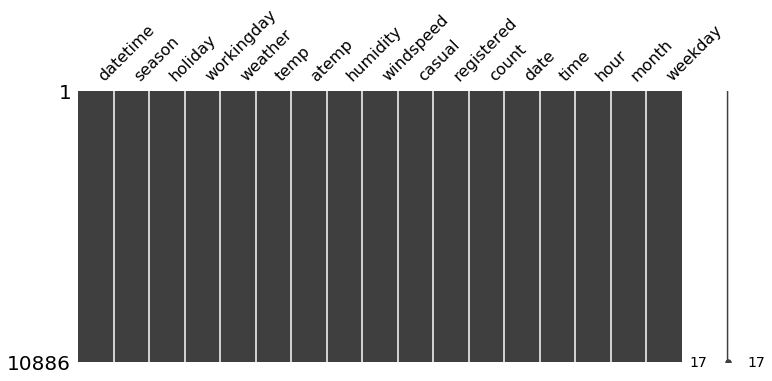

In [10]:
#check for missing values
df_train.info()
df_train.isnull().sum()
#visualise missing values
msno.matrix(df_train, figsize = (12, 5))

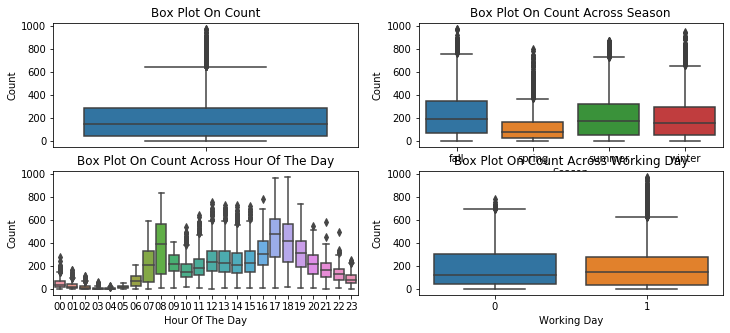

In [13]:
#outlier analysis using boxplots
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12, 5)
sn.boxplot(data = df_train, y = 'count', orient = 'v', ax = axes[0][0])
sn.boxplot(data = df_train, y = 'count', x = 'season', orient = 'v', ax = axes[0][1])
sn.boxplot(data = df_train, y = 'count', x = 'hour', orient = 'v', ax = axes[1][0])
sn.boxplot(data = df_train, y = 'count', x = 'workingday', orient = 'v', ax = axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#remove outlier count values from df_train
df_NoOutliers = df_train[np.abs(df_train['count'] - df_train['count'].mean()) <= (3* df_train['count'].std())]

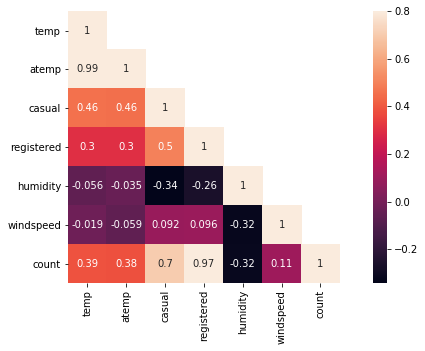

In [14]:
#Correlation analysis using seaborn regression plot
corrMatt = df_NoOutliers[['temp', 'atemp', 'casual', 'registered', 'humidity', 'windspeed', 'count']].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sn.heatmap(corrMatt, mask = mask, vmax = 0.8, square = True, annot = True)

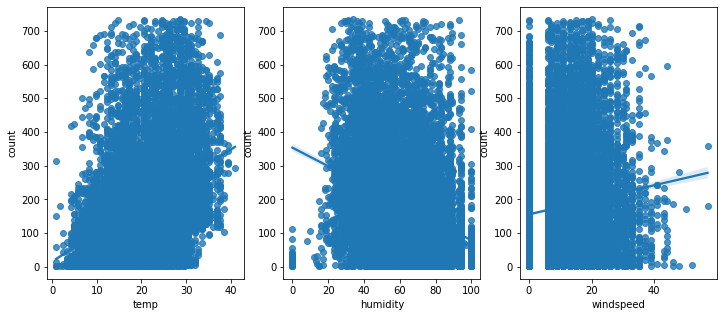

In [15]:
#More visualization
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12, 5)
sn.regplot(x = 'temp', y = 'count', data = df_NoOutliers, ax = ax1)
sn.regplot(x = 'humidity', y = 'count', data = df_NoOutliers, ax = ax2)
sn.regplot(x = 'windspeed', y = 'count', data = df_NoOutliers, ax = ax3)

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.409684610154291, 4.523106928071492, 0.9537631807794263))

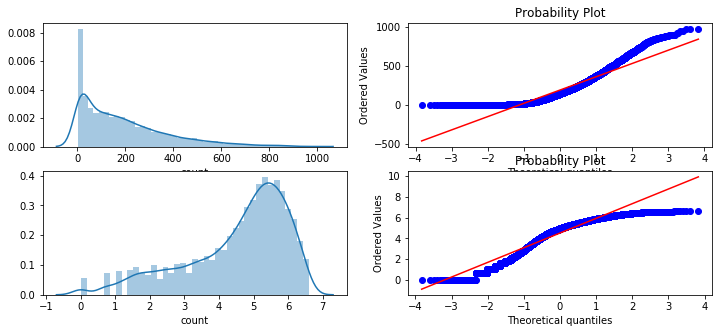

In [16]:
#More Visualisation to check for normal distribution of count column
fig, axes = plt.subplots(ncols = 2, nrows = 2)
fig.set_size_inches(12, 5)
sn.distplot(df_train['count'], ax = axes[0][0])
stats.probplot(df_train['count'], dist = 'norm', fit = True, plot = axes[0][1])
sn.distplot(np.log(df_NoOutliers['count']), ax = axes[1][0])
stats.probplot(np.log(df_NoOutliers['count']), dist = 'norm', fit = True, plot = axes[1][1])

[Text(0, 0.5, 'User Count'),
 Text(0.5, 0, 'Hour'),
 Text(0.5, 1.0, 'User Count by hour accross weekdays')]

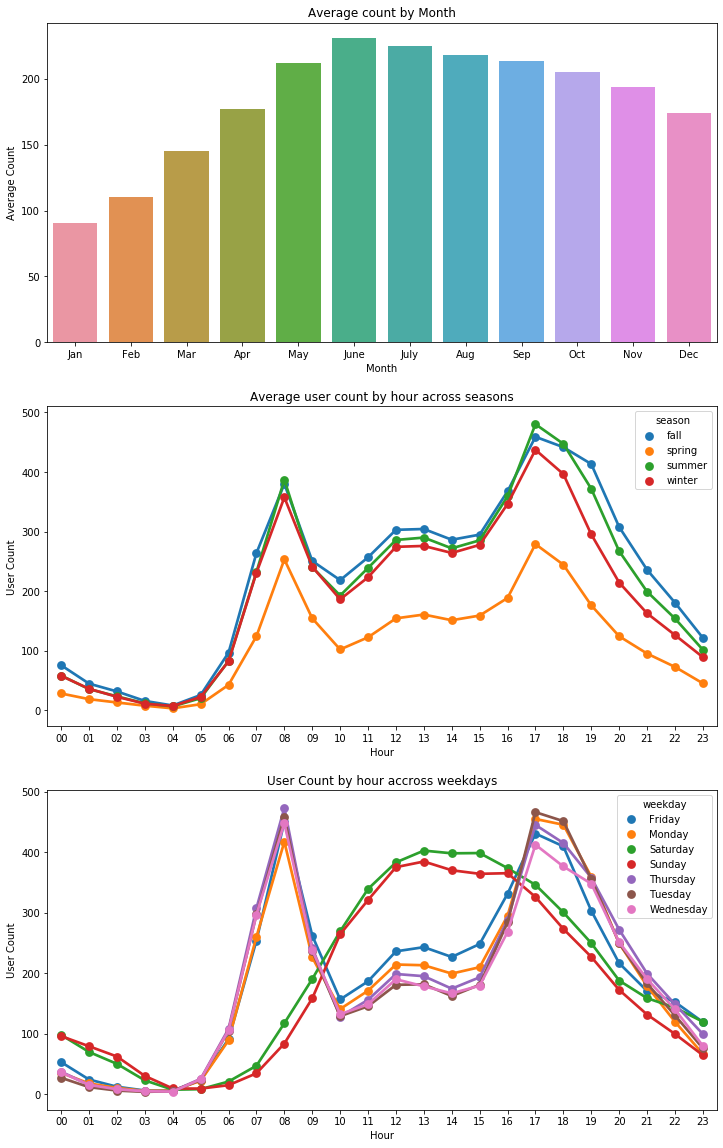

In [17]:
#More Visualization count vs (month, hour, season, weekday, usertype)
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3)
fig.set_size_inches(12, 20)

sort = ["Jan","Feb","Mar","Apr","May","June","July","Aug","Sep","Oct","Nov","Dec"]

monthAggregated = pd.DataFrame(df_NoOutliers.groupby('month')['count'].mean()).reset_index()
sn.barplot(data = monthAggregated, x = 'month', y = 'count', ax = ax1, order = sort)
ax1.set(xlabel = 'Month', ylabel = 'Average Count', title = 'Average count by Month')

hourAggregated = pd.DataFrame(df_NoOutliers.groupby(['hour', 'season'])['count'].mean()).reset_index()
sn.pointplot(data = hourAggregated, x = hourAggregated['hour'], y = hourAggregated['count'], 
             hue = hourAggregated['season'], join = True, ax = ax2)
ax2.set(xlabel = 'Hour', ylabel = 'User Count', title = 'Average user count by hour across seasons')

hourAggregated = pd.DataFrame(df_NoOutliers.groupby(['hour', 'weekday'])['count'].mean()).reset_index()
sn.pointplot(data = hourAggregated, x = hourAggregated['hour'], y = hourAggregated['count'], 
             hue = hourAggregated['weekday'], season = True, ax = ax3)
ax3.set(xlabel = 'Hour', ylabel = 'User Count', title = 'User Count by hour accross weekdays')



In [18]:
#Filling the 0's in windspeed with random forest
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
df_data = data_train.append(data_test)
df_data.reset_index(inplace = True)
df_data.drop('index', inplace = True, axis = 1)

features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity']
df_train = df_data[df_data['windspeed'] != 0]
df_test = df_data[df_data['windspeed'] == 0]
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0.0,1.0,1.0
10,2011-01-01 10:00:00,1,0,0,1,15.58,19.695,76,16.9979,12.0,24.0,36.0
11,2011-01-01 11:00:00,1,0,0,1,14.76,16.665,81,19.0012,26.0,30.0,56.0
12,2011-01-01 12:00:00,1,0,0,1,17.22,21.210,77,19.0012,29.0,55.0,84.0
13,2011-01-01 13:00:00,1,0,0,2,18.86,22.725,72,19.9995,47.0,47.0,94.0


In [19]:
rf_model = RandomForestRegressor()
rf_model.fit(df_train[features], df_train['windspeed'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [20]:
df_test['windspeed'] = rf_model.predict(X = df_test[features])
df_data = df_train.append(df_test)
df_data.reset_index(inplace = True)
df_data.drop('index', inplace = True, axis = 1)
df_data.head()
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


C:\Users\chith\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_data['date'] = df_data.datetime.apply(lambda x: x.split()[0])
df_data['hour'] = df_data.datetime.apply(lambda x: x.split()[1].split(':')[0])
df_data['year'] = df_data.date.apply(lambda x: x.split('-')[0])
df_data['month'] = df_data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
df_data['weekday'] = df_data.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').weekday())

In [22]:
categorical_features = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'weekday', 'hour']
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed']
drop_features = ['datetime', 'date', 'casual', 'registered', 'count']

In [23]:
for var in categorical_features:
    df_data[var] = df_data[var].astype('category')

In [24]:
data_train = df_data[pd.notnull(df_data['count'])].sort_values(by = ['datetime'])
data_test = df_data[~pd.notnull(df_data['count'])].sort_values(by = ['datetime'])
yLabels = data_train['count']
datetimeCol = data_test['datetime']
yLabelsRegistered = data_train['registered']
yLablesCasual = data_train['casual']

In [25]:
data_train = data_train.drop(drop_features, axis = 1)
data_test = data_test.drop(drop_features, axis = 1)

In [49]:
#split existing train set into two train and test set
X_train, X_test, y_train, y_test = train_test_split(data_train, yLabels, test_size = 0.25)

#convert train and test labels to log value for rmsle
ytrainLog = np.log1p(y_train)
ytestLog = np.log1p(y_test)

In [59]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [58]:
#Linear Regression model
lmodel = LinearRegression()
lmodel.fit(X_train, ytrainLog)

predictions = lmodel.predict(X_test)
np.sqrt(mean_squared_log_error( np.exp(ytestLog), np.exp(predictions)))

0.9955937904865508

In [60]:
#Ridge Regression
r_model = Ridge()
ridge_params = {'max_iter': [3000], 'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)
grid_ridge_m = GridSearchCV(r_model, ridge_params, scoring = rmsle_scorer, cv = 5)
grid_ridge_m.fit(X_train, ytrainLog)
predictions = grid_ridge_m.predict(X = X_test)
print(np.sqrt(mean_squared_log_error( np.exp(ytestLog), np.exp(predictions))))
print(grid_ridge_m.best_params_)

0.9957952972542619
{'alpha': 100, 'max_iter': 3000}


In [61]:
#Lasso Regression
lasso_model = Lasso()
alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter': [3000], 'alpha': alpha}
grid_lasso_m = GridSearchCV(lasso_model, lasso_params, scoring = rmsle_scorer, cv = 5)
grid_lasso_m.fit(X_train, ytrainLog)
predictions = grid_lasso_m.predict(X = X_test)
print(grid_lasso_m.best_params_)
print(np.sqrt(mean_squared_log_error( np.exp(ytestLog), np.exp(predictions))))

{'alpha': 0.005, 'max_iter': 3000}
0.9958104545937888


In [62]:
#Random Forest Regression
randomf_model = RandomForestRegressor(n_estimators = 100)
randomf_model.fit(X_train, ytrainLog)
predictions = randomf_model.predict(X_test)
print(np.sqrt(mean_squared_log_error( np.exp(ytestLog), np.exp(predictions))))

0.2872533494622327


In [63]:
#Gradient Boosting Regressor
gradientb_model = GradientBoostingRegressor(n_estimators = 4000, alpha = 0.01)
gradientb_model.fit(X_train, ytrainLog)
predictions = gradientb_model.predict(X_test)
print(np.sqrt(mean_squared_log_error( np.exp(ytestLog), np.exp(predictions))))

0.2634465947057379


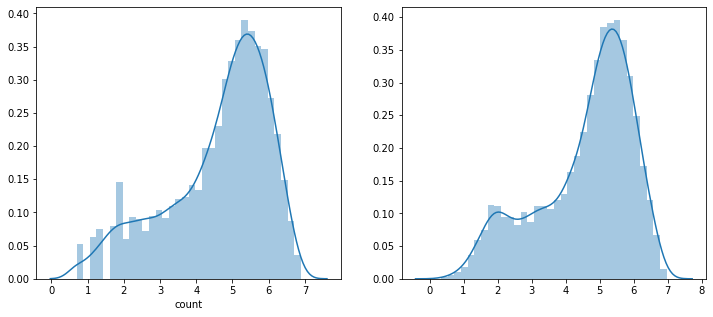

In [65]:
#predict on actual test data and check for overfitting by plotting
pred_test = gradientb_model.predict(data_test)
fig, (ax1, ax2) = plt.subplots(ncols = 2)
fig.set_size_inches(12, 5)
sn.distplot(ytrainLog, ax  = ax1)
sn.distplot(pred_test, ax = ax2)
